In [95]:
import os
import scipy.io

# Đường dẫn tới thư mục chứa các file .mat đã giải nén
data_root = 'eeg_data'

# Lấy danh sách tất cả các file .mat trong thư mục
mat_files = [f for f in os.listdir(data_root) if f.endswith('.mat')]

# Duyệt qua từng file .mat
for mat_file in mat_files:
    mat_file_path = os.path.join(data_root, mat_file)
    
    # Đọc file .mat
    mat = scipy.io.loadmat(mat_file_path)

    # Trích xuất thông tin từ trường 'o'
    try:
        # Truy xuất sample frequency (sampFreq)
        samp_freq = mat['o']['sampFreq'][0, 0][0][0]

        # Truy xuất dữ liệu (data)
        data = mat['o']['data'][0, 0]

        # In ra thông tin kiểm tra
        print(f"File: {mat_file}")
        print(f"Sample Frequency: {samp_freq}")
        print(f"Data Shape: {data.shape}")
        print(f"First 5 data points:\n{data[:5]}")
    
    except KeyError as e:
        print(f"Missing key in file {mat_file}: {e}")


File: eeg_record1.mat
Sample Frequency: 128
Data Shape: (308868, 25)
First 5 data points:
[[3.00000000e+00 0.00000000e+00 4.63000000e+02 4.44000000e+03
  4.41794872e+03 5.39076923e+03 3.83384615e+03 4.01948718e+03
  4.65641026e+03 4.74205128e+03 4.41538462e+03 4.53846154e+03
  4.30820513e+03 4.12564103e+03 4.28358974e+03 4.33538462e+03
  4.56358974e+03 1.57300000e+03 1.72600000e+03 7.64304000e+02
  3.12768780e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.00000000e+00 0.00000000e+00 0.00000000e+00 4.43948718e+03
  4.41794872e+03 5.38923077e+03 3.83025641e+03 4.02000000e+03
  4.65897436e+03 4.73897436e+03 4.41487179e+03 4.53589744e+03
  4.30820513e+03 4.13641026e+03 4.28461538e+03 4.33179487e+03
  4.56666667e+03 1.57000000e+03 1.72700000e+03 7.64304000e+02
  3.12768780e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.00000000e+00 0.00000000e+00 4.47000000e+02 4.43897436e+03
  4.41487179e+03 5.38564103e+03 3.82974359e+03 4.01794872e+03
  4.65

In [96]:
channel_indices = np.array(range(4, 17))
channel_names = ['F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
channel_map = dict(zip(channel_names, channel_indices))

In [97]:
df = pd.DataFrame.from_dict(data)

Text(0, 0.5, 'EEG channel F7')

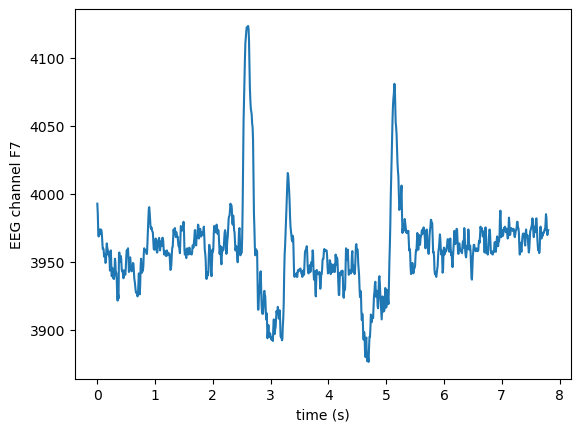

In [98]:
i_ch = 0
time = np.arange(1000) / samp_freq
channel = data[:1000, channel_indices[i_ch]]
plt.plot(time, channel)
plt.xlabel('time (s)')
plt.ylabel(f'EEG channel {channel_names[i_ch]}')

In [71]:
states = {
 'focused': data[:samp_freq * 10 * 60, :],
  'unfocused': data[samp_freq * 10 * 60:samp_freq * 20 * 60, :],
  'drowsy': data[samp_freq * 30 * 60:, :],
}

In [73]:
bands = {'alpha': (8, 13), 'delta': (0.5, 4), 'beta': (13, 30), 'gamma': (30, np.inf)}

In [75]:
def get_data(filename):
    mat = scipy.io.loadmat(os.path.join(data_root, filename))
    data = mat['o']['data'][0, 0]
    FS = mat['o']['sampFreq'][0][0][0][0]

    states = {
     'focused': data[:FS * 10 * 60, :],
      'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
      'drowsy': data[FS * 30 * 60:, :],
    }
    return states

In [77]:
def get_powers(channel, FS=128):
    channel = channel - channel.mean()
    freq, psd = signal.periodogram(channel, fs=FS, nfft=256)

    powers = {}
    for band_name, band_limits in bands.items():
        low, high = band_limits
        powers[band_name] = psd[(freq >= low) & (freq < high)].mean()
    return powers

In [79]:
subjects = [5, 10, 20, 25, 33]

In [81]:
rows_list = []
for subject_idx in subjects:
    states = get_data(f"eeg_record{subject_idx}.mat")
    for ch_name, ch_idx in channel_map.items():
        for state, eeg in states.items():
            powers = get_powers(eeg[:, ch_idx])
            powers['state'] = state
            powers['channel'] = ch_name
            powers['subject'] = f"subject_{subject_idx}"
            rows_list.append(powers)

In [83]:
df = pd.DataFrame.from_dict(rows_list)

In [85]:
df.head()

,alpha,delta,beta,gamma,state,channel,subject
0,1.927219,36.255531,0.892434,0.213194,focused,AF3,subject_5
1,1.758539,36.506171,0.590528,0.163570,unfocused,AF3,subject_5
2,1.475614,5.884436,0.378233,0.055416,drowsy,AF3,subject_5
3,3.905914,208.404241,0.784781,0.278974,focused,F7,subject_5
4,1.305990,59.029347,0.330566,0.085149,unfocused,F7,subject_5
